In [95]:
import gzip        
import pickle    
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from scipy.signal import find_peaks



In [96]:
def mesh_index_to_km(x):
    return (x / 299) * 110

def km_to_mesh_index(x):
    return (x / 110) * 299

In [97]:
def get_GL_index(gl_array):
    gl_array = np.array(gl_array).astype(int)
    for i in range(1, len(gl_array)):
        if gl_array[i-1] == 0 and gl_array[i] == 1:
            return i
    return None

# INPUT: TEST VARIABLE + TEST VALUE + FILEPATH

In [98]:
variable = "Base"
value = "NA"
path = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_21__21_38_21.pkl.gz"
with gzip.open(path, 'rb') as f:
    DATA_dict = pickle.load(f)



title_GL_basic = "Grounding Line Evolution: " + variable + " " + value
xaxis_GL_basic = "Mesh Index"
yaxis_GL_basic = "Timestep (yrs)"

title_GL_better = "Grounding Line Evolution: " + variable + " " + value
xaxis_GL_better = "Time (yrs)"
yaxis_GL_better = "Grounding Line Position (km)"

title_GLandVel = "Velocity Comparison to Grounding Line Location"
xaxis_vel = xaxis_GL_better
yaxis_vel  = "Velocity (m/yr)"

title_H = ""
xaxis_H = ""
yaxis_H = ""

title_bed = "Bedrock Erosion Evolution"
xaxis_bed = "Distance (km)"
yaxis_bed = "Surface Elevation (m)"

print(title_GL_basic)

Grounding Line Evolution: Base NA


## OPENING INDIVIDUAL DICTIONARIES

In [109]:
bed_dict = DATA_dict['bed_dict']
base_dict = DATA_dict['base_dict']
surf_dict = DATA_dict['surf_dict']
sed_dict = DATA_dict['sed_dict']
H_dict = DATA_dict['H_dict']
us_dict = DATA_dict['us_dict']
ub_dict = DATA_dict['ub_dict']
Hs_dict = DATA_dict['Hs_dict']
GL_dict = DATA_dict['GL_dict']
Qs_dict = DATA_dict['Qs_dict']
SMB_dict = DATA_dict['SMB_dict']
counter_dict = DATA_dict['counter_dict']


## BASIC GL PLOT

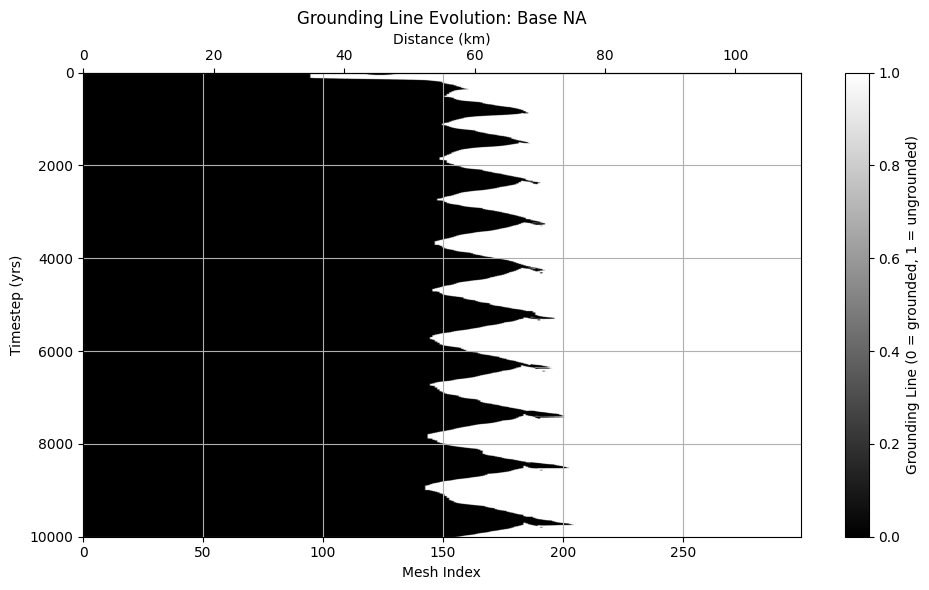

In [100]:
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)
ax.set_ylabel(yaxis_GL_basic)
ax.set_xlabel(xaxis_GL_basic)
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(title_GL_basic)
ax.set_ylim(10000)


# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.grid()
plt.show()

## BETTER GL PLOT

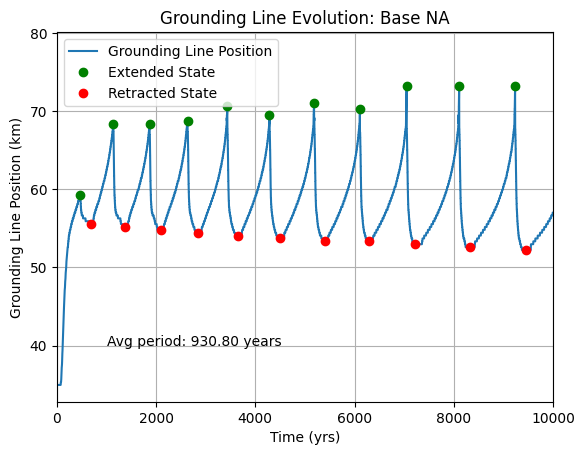

Mean cycle period: 930.80 years
[ 671.04104519  731.17664818  765.35723967  801.83053734  850.85569445
  897.86178343  923.5788195   943.37435896 1058.89407233 1127.75294557
 1205.86071133 1266.38591253 1305.65302515 1478.12606562    2.60391782
   10.54831152 1705.60234775 1930.32962006    8.45332891]
Mean advance amplitude: 71.57 km
[59.23076923 68.42809365 68.42809365 68.79598662 70.63545151 69.53177258
 71.00334448 70.26755853 73.21070234 73.21070234 73.21070234 73.94648829
 73.57859532 72.84280936 71.00334448 71.73913043 77.99331104 76.15384615
 71.73913043 76.52173913]
Mean retreat amplitude: 55.29 km
[55.55183946 55.18394649 54.81605351 54.44816054 54.08026756 53.71237458
 53.34448161 53.34448161 52.97658863 52.60869565 52.24080268 51.8729097
 51.8729097  51.50501672 68.42809365 68.79598662 51.13712375 50.76923077
 68.79598662 50.40133779]


In [101]:
gl_positions = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions.append(idx)

gl_positions = np.array(gl_positions)
GL_km = mesh_index_to_km(gl_positions)

peaks, _ = find_peaks(GL_km, prominence=2) 
troughs, _ = find_peaks(-GL_km, prominence=2)     
periods = np.diff(np.array(time)[peaks])
adv_dists = GL_km[peaks]
ret_dists = GL_km[troughs]


plt.plot(time, GL_km, label='Grounding Line Position')
plt.plot(np.array(time)[peaks], GL_km[peaks], 'go', label='Extended State')
plt.plot(np.array(time)[troughs], GL_km[troughs], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlim(0,10000)
plt.xlabel(xaxis_GL_better)
plt.ylabel(yaxis_GL_better)
plt.title(title_GL_better )
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods):.2f} years")
print(periods)

print(f"Mean advance amplitude: {np.mean(adv_dists):.2f} km")
print(adv_dists)

print(f"Mean retreat amplitude: {np.mean(ret_dists):.2f} km")
print(ret_dists)


### Pulling Velocity Data

In [102]:
term_surface_velocity = []
term_basal_velocity = []

for t in sorted(us_dict.keys()):  # loop over timesteps
    us_ = us_dict[t]
    ub_ = ub_dict[t]

    notNAN = np.where(np.isfinite(us_))[0]

    if len(notNAN) > 0:
        terminus = notNAN[-1]
    else:
        terminus = None

    if terminus is not None and terminus >= 50:
        term_usvel = us_[terminus - 50]
        term_ubvel = ub_[terminus - 50]
    else:
        term_usvel = 0
        term_ubvel = 0

    if np.isnan(term_usvel):
        term_usvel = 0
    if np.isnan(term_ubvel):
        term_ubvel = 0

    term_surface_velocity.append(term_usvel)
    term_basal_velocity.append(term_ubvel)

## VELOCITY OVER GL PLOT

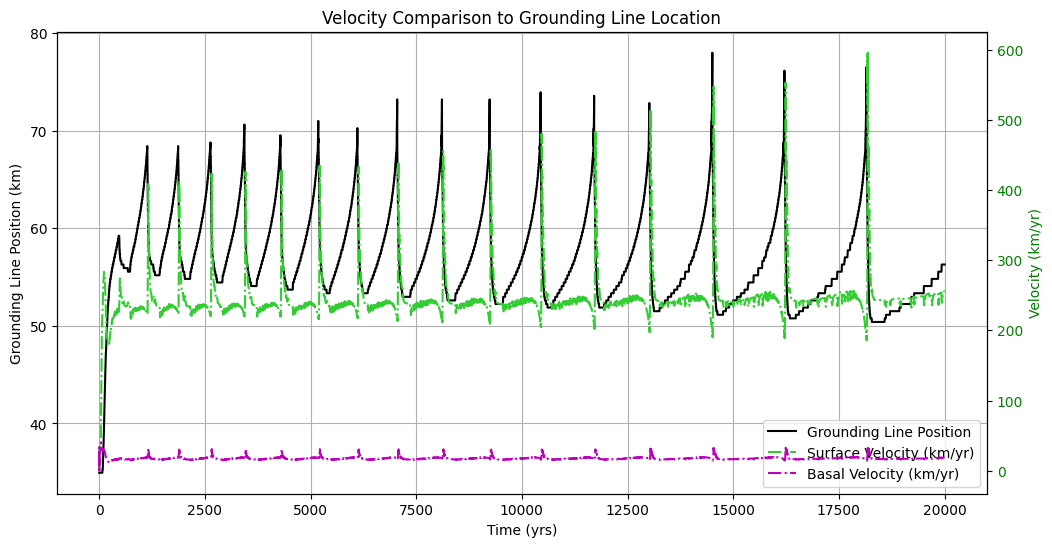

In [103]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# GL position
ax1.plot(time, GL_km, label='Grounding Line Position', color='black')
ax1.set_xlabel(xaxis_vel)
ax1.set_ylabel(yaxis_GL_better, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid()

# Secondary axis for velocities
ax2 = ax1.twinx()
ax2.plot(time, term_surface_velocity, 'limegreen', ls = '-.', label='Surface Velocity (km/yr)')
ax2.plot(time, term_basal_velocity, 'm-.', label='Basal Velocity (km/yr)')
ax2.set_ylabel("Velocity (km/yr)", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower right')

plt.title(title_GLandVel)
plt.show()

## BED ELEVATION CHANGE PLOT

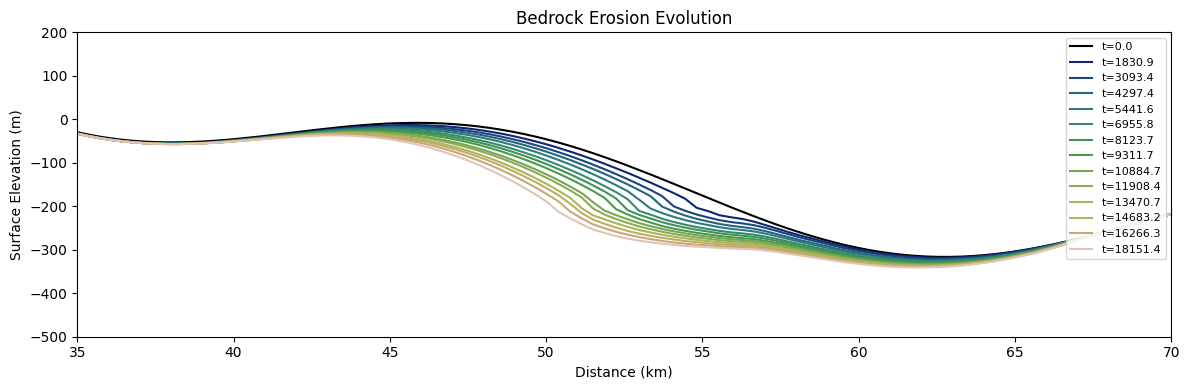

In [104]:
num_points = len(next(iter(bed_dict.values())))
x_km = mesh_index_to_km(np.arange(num_points))
time = list(bed_dict.keys())
# bed_profile = bed_dict[timesteps[0]] 
norm = plt.Normalize(min(time), max(time))
cmap = cm.gist_earth

plt.figure(figsize=(12,4))

for i, t in enumerate(time):
    if i % 1000 != 0:  
        continue

    bed = bed_dict[t]
    color = cmap(norm(t))
    plt.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

plt.xlabel(xaxis_bed)
plt.ylabel(yaxis_bed)
plt.title(title_bed)
# plt.gca().invert_xaxis() 
plt.legend(loc="best", fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.xlim(35,70)
plt.ylim(-500,200)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

## SMB PLOT

KeyError: 1

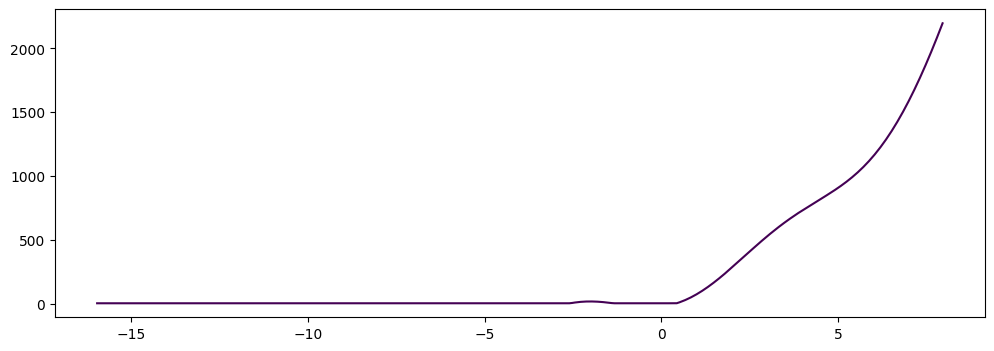

In [117]:
num_points = len(next(iter(surf_dict.values())))  # number of spatial points
timesteps = sorted(SMB_dict.keys())
smb_profile = SMB_dict[timesteps[0]] 
norm = plt.Normalize(min(timesteps), max(timesteps))
cmap = cm.viridis
counts = 

plt.figure(figsize=(12,4))

# num_lines = 50  # number of lines you want
# sample_indices = np.linspace(0, len(timesteps)-1, num_lines, dtype=int)

for c, t in counter_dict.items():
    surf = surf_dict[t]
    color = cmap(norm(t))
    plt.plot(smb_profile, surf, color=color)


# for i, t in enumerate(timesteps):
#     if i % 2 == 0:  
#         continue

#     surf = surf_dict[t]
#     color = cmap(norm(t))
#     plt.plot(smb_profile, surf, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

plt.xlabel("SMB (m/yr)")
plt.ylabel("Surface Elevation (m)")
plt.title("Glacier Surface VS Accumulation/Ablation")
plt.gca().invert_xaxis() 
plt.legend(loc="best", fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()